# Graph Neural Networks


**Note**: The following three sections: **Graph represetation**, **Graph Convolutions** and **Grap Attention** are from UvA Deep Learning Tutorials. 

Course website: https://uvadlc.github.io/

Repository: https://github.com/phlippe/uvadlc_notebooks

Author: Phillip Lippe

Graph Neural Networks (GNNs) have recently gained increasing popularity in both applications and research, including domains such as social networks, knowledge graphs, recommender systems, and bioinformatics. We will discuss the implementation of basic network layers of a GNN, namely graph convolutions, and attention layers. Finally, we will apply a GNN on a node-level tasks.



### Graph representation

Before starting the discussion of specific neural network operations on graphs, we should consider how to represent a graph. Mathematically, a graph $\mathcal{G}$ is defined as a tuple of a set of nodes/vertices $V$, and a set of edges/links $E$: $\mathcal{G}=(V,E)$. Each edge is a pair of two vertices, and represents a connection between them. For instance, let's look at the following graph:

<center width="100%" style="padding:10px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial7/example_graph.svg?raw=1" width="250px"></center>

The vertices are $V=\{1,2,3,4\}$, and edges $E=\{(1,2), (2,3), (2,4), (3,4)\}$. Note that for simplicity, we assume the graph to be undirected and hence don't add mirrored pairs like $(2,1)$. In application, vertices and edge can often have specific attributes, and edges can even be directed. The question is how we could represent this diversity in an efficient way for matrix operations. Usually, for the edges, we decide between two variants: an adjacency matrix, or a list of paired vertex indices. 

The **adjacency matrix** $A$ is a square matrix whose elements indicate whether pairs of vertices are adjacent, i.e. connected, or not. In the simplest case, $A_{ij}$ is 1 if there is a connection from node $i$ to $j$, and otherwise 0. If we have edge attributes or different categories of edges in a graph, this information can be added to the matrix as well. For an undirected graph, keep in mind that $A$ is a symmetric matrix ($A_{ij}=A_{ji}$). For the example graph above, we have the following adjacency matrix:

$$
A = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix}
$$

While expressing a graph as a list of edges is more efficient in terms of memory and (possibly) computation, using an adjacency matrix is more intuitive and simpler to implement. In our implementations below, we will rely on the adjacency matrix to keep the code simple. However, common libraries use edge lists, which we will discuss later more.
Alternatively, we could also use the list of edges to define a sparse adjacency matrix with which we can work as if it was a dense matrix, but allows more memory-efficient operations. PyTorch supports this with the sub-package `torch.sparse` ([documentation](https://pytorch.org/docs/stable/sparse.html)) which is however still in a beta-stage (API might change in future).

### Graph Convolutions

Graph Convolutional Networks have been introduced by [Kipf et al.](https://openreview.net/pdf?id=SJU4ayYgl) in 2016 at the University of Amsterdam. He also wrote a great [blog post](https://tkipf.github.io/graph-convolutional-networks/) about this topic, which is recommended if you want to read about GCNs from a different perspective. GCNs are similar to convolutions in images in the sense that the "filter" parameters are typically shared over all locations in the graph. At the same time, GCNs rely on message passing methods, which means that vertices exchange information with the neighbors, and send "messages" to each other. Before looking at the math, we can try to visually understand how GCNs work. The first step is that each node creates a feature vector that represents the message it wants to send to all its neighbors. In the second step, the messages are sent to the neighbors, so that a node receives one message per adjacent node. Below we have visualized the two steps for our example graph. 

<center width="100%" style="padding:10px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial7/graph_message_passing.svg?raw=1" width="700px"></center>

If we want to formulate that in more mathematical terms, we need to first decide how to combine all the messages a node receives. As the number of messages vary across nodes, we need an operation that works for any number. Hence, the usual way to go is to sum or take the mean. Given the previous features of nodes $H^{(l)}$, the GCN layer is defined as follows:

$$H^{(l+1)} = \sigma\left(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W^{(l)}\right)$$

$W^{(l)}$ is the weight parameters with which we transform the input features into messages ($H^{(l)}W^{(l)}$). To the adjacency matrix $A$ we add the identity matrix so that each node sends its own message also to itself: $\hat{A}=A+I$. Finally, to take the average instead of summing, we calculate the matrix $\hat{D}$ which is a diagonal matrix with $D_{ii}$ denoting the number of neighbors node $i$ has. $\sigma$ represents an arbitrary activation function, and not necessarily the sigmoid (usually a ReLU-based activation function is used in GNNs). 

When implementing the GCN layer in PyTorch, we can take advantage of the flexible operations on tensors. Instead of defining a matrix $\hat{D}$, we can simply divide the summed messages by the number of neighbors afterward. Additionally, we replace the weight matrix with a linear layer, which additionally allows us to add a bias. Written as a PyTorch module, the GCN layer is defined as follows:

In [1]:
import torch
import torch.nn as nn

In [2]:
class GCNLayer(nn.Module):
    
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections. 
                         Shape: [batch_size, num_nodes, num_nodes]
        """

        
        """ ***implement the GCN layer*** """
        # approximately 4 lines, 
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

To further understand the GCN layer, we can apply it to our example graph above. First, let's specify some node features and the adjacency matrix with added self-connections:

In [3]:
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


Next, let's apply a GCN layer to it. For simplicity, we initialize the linear weight matrix as an identity matrix so that the input features are equal to the messages. This makes it easier for us to verify the message passing operation.

In [4]:
layer = GCNLayer(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


As we can see, the first node's output values are the average of itself and the second node. Similarly, we can verify all other nodes. However, in a GNN, we would also want to allow feature exchange between nodes beyond its neighbors. This can be achieved by applying multiple GCN layers, which gives us the final layout of a GNN. The GNN can be build up by a sequence of GCN layers and non-linearities such as ReLU. For a visualization, see below (figure credit - [Thomas Kipf, 2016](https://tkipf.github.io/graph-convolutional-networks/)).

<center width="100%" style="padding: 10px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial7/gcn_network.png?raw=1" width="600px"></center>

However, one issue we can see from looking at the example above is that the output features for nodes 3 and 4 are the same because they have the same adjacent nodes (including itself). Therefore, GCN layers can make the network forget node-specific information if we just take a mean over all messages. Multiple possible improvements have been proposed. While the simplest option might be using residual connections, the more common approach is to either weigh the self-connections higher or define a separate weight matrix for the self-connections. Alternatively, we can re-visit a concept from the last tutorial: attention. 

### Graph Attention 

Attention describes a weighted average of multiple elements with the weights dynamically computed based on an input query and elements' keys. This concept can be similarly applied to graphs, one of such is the Graph Attention Network (called GAT, proposed by [Velickovic et al., 2017](https://arxiv.org/abs/1710.10903)). Similarly to the GCN, the graph attention layer creates a message for each node using a linear layer/weight matrix. For the attention part, it uses the message from the node itself as a query, and the messages to average as both keys and values (note that this also includes the message to itself). The score function $f_{attn}$ is implemented as a one-layer MLP which maps the query and key to a single value. The MLP looks as follows (figure credit - [Velickovic et al.](https://arxiv.org/abs/1710.10903)):

<center width="100%" style="padding:10px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial7/graph_attention_MLP.svg?raw=1" width="250px"></center>

$h_i$ and $h_j$ are the original features from node $i$ and $j$ respectively, and represent the messages of the layer with $\mathbf{W}$ as weight matrix. $\mathbf{a}$ is the weight matrix of the MLP, which has the shape $[1,2\times d_{\text{message}}]$, and $\alpha_{ij}$ the final attention weight from node $i$ to $j$. The calculation can be described as follows:

$$\alpha_{ij} = \frac{\exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)\right)}$$

The operator $||$ represents the concatenation, and $\mathcal{N}_i$ the indices of the neighbors of node $i$. Note that in contrast to usual practice, we apply a non-linearity (here LeakyReLU) before the softmax over elements. Although it seems like a minor change at first, it is crucial for the attention to depend on the original input. Specifically, let's remove the non-linearity for a second, and try to simplify the expression:

$$
\begin{split}
    \alpha_{ij} & = \frac{\exp\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i+\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i+\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i\right)\cdot\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i\right)\cdot\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\
\end{split}
$$

We can see that without the non-linearity, the attention term with $h_i$ actually cancels itself out, resulting in the attention being independent of the node itself. Hence, we would have the same issue as the GCN of creating the same output features for nodes with the same neighbors. This is why the LeakyReLU is crucial and adds some dependency on $h_i$ to the attention. 

Once we obtain all attention factors, we can calculate the output features for each node by performing the weighted average:

$$h_i'=\sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}\mathbf{W}h_j\right)$$

$\sigma$ is yet another non-linearity, as in the GCN layer. Visually, we can represent the full message passing in an attention layer as follows (figure credit - [Velickovic et al.](https://arxiv.org/abs/1710.10903)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial7/graph_attention.jpeg?raw=1" width="400px"></center>

To increase the expressiveness of the graph attention network, [Velickovic et al.](https://arxiv.org/abs/1710.10903) proposed to extend it to multiple heads similar to the Multi-Head Attention block in Transformers. This results in $N$ attention layers being applied in parallel. In the image above, it is visualized as three different colors of arrows (green, blue, and purple) that are afterward concatenated. The average is only applied for the very final prediction layer in a network. 

After having discussed the graph attention layer in detail, we can implement it below:

In [15]:
class GATLayer(nn.Module):
    
    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The 
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads
        
        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out)) # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)
        
        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)
        

        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)
        
        # We need to calculate the attention logits for every edge in the adjacency matrix 
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        edges = adj_matrix.nonzero(as_tuple=False) # Returns indices where the adjacency matrix is not 0 => edges
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:,0] * num_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * num_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)
        ], dim=-1) # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0
        
        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a) 
        attn_logits = self.leakyrelu(attn_logits)
        
        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)
        
        m = nn.Softmax(dim=2)
        attn_probs = m(attn_matrix)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)
        
        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)
        
        return node_feats 

Now let's implement the GAT layer

In [16]:
""" 
***
apply the graph attention layer with the same input the GCN layer, use same weights and bias
use two heads to show the parallel, set a to be a vector of arbitrary numbers to obtain different attention values.
print out the the output features
briefly comment on the difference to the output from the GCN layer
***
"""
layer = GATLayer(2, 2, num_heads=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])
layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs=True)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Attention probs
 tensor([[[[0.3543, 0.6457, 0.0000, 0.0000],
          [0.1096, 0.1450, 0.2642, 0.4813],
          [0.0000, 0.1858, 0.2885, 0.5257],
          [0.0000, 0.2391, 0.2696, 0.4913]],

         [[0.5100, 0.4900, 0.0000, 0.0000],
          [0.2975, 0.2436, 0.2340, 0.2249],
          [0.0000, 0.3838, 0.3142, 0.3019],
          [0.0000, 0.4018, 0.3289, 0.2693]]]])
Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1.2913, 1.9800],
         [4.2344, 3.7725],
         [4.6798, 4.8362],
         [4.5043, 4.7351]]])


## PyTorch Geometric

Implementing graph networks with adjacency matrix is simple and straight-forward but can be computationally expensive for large graphs. Many real-world graphs can reach over 200k nodes, for which adjacency matrix-based implementations fail. There are a lot of optimizations possible when implementing GNNs, and luckily, there exist packages that provide such layers. The most popular packages for PyTorch are [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) and the [Deep Graph Library](https://www.dgl.ai/) (the latter being actually framework agnostic). Which one to use depends on the project you are planning to do and personal taste. In this tutorial, we will look at PyTorch Geometric as part of the PyTorch family.

In [17]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 6.8 MB/s 
     |████████████████████████████████| 4.6 MB 8.0 MB/s 
     |████████████████████████████████| 280 kB 8.0 MB/s 


In [18]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [19]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by th following procedure. We make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [20]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [21]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


## Training a Graph Neural Network (GNN)

In [24]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        """ ***complete the model, replace the linear layers by the GCN layers** """
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        """ ***complete the forward pass*** """
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


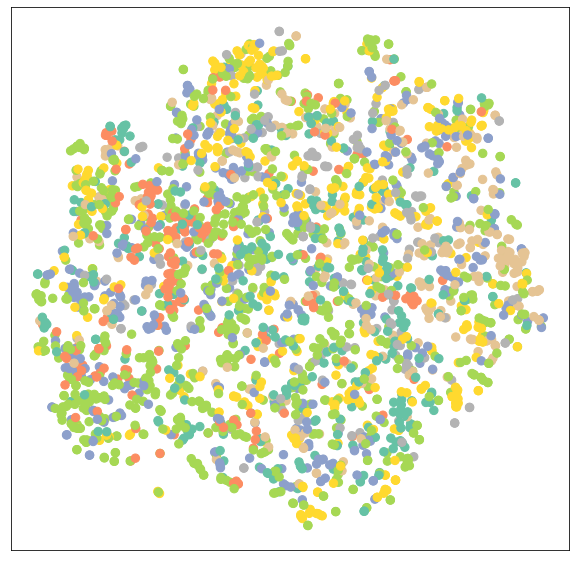

In [25]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [26]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


After training the model, we can check its test accuracy:

In [27]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


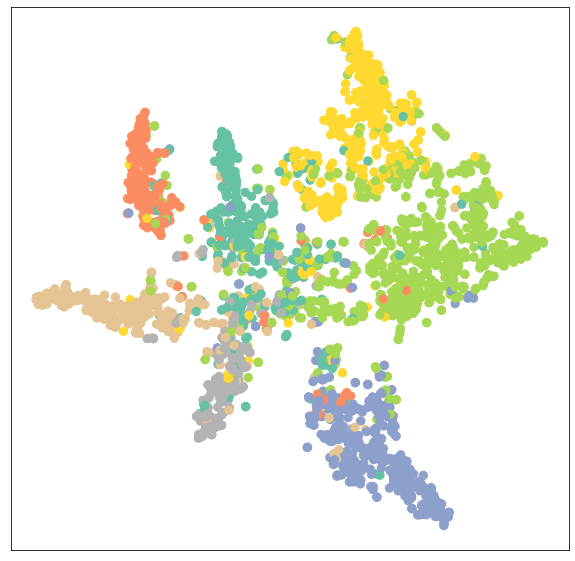

In [28]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

 What happens if you swap out all `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

In [30]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        """ ***implement the GAT layers*** """
        self.hid = 8
        self.in_head = 8
        self.out_head = 1

        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6) 
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)  

    def forward(self, x, edge_index):
        """ ***complete the forward pass*** """
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)
 

model = GAT(hidden_channels=8, heads=8)
print(model)

""" ***define the optimizer and criterion*** """
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
# criterion = F.nll_loss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
Epoch: 001, Loss: 1.9436, Val: 0.1980, Test: 0.2190
Epoch: 002, Loss: 1.9379, Val: 0.3280, Test: 0.3200
Epoch: 003, Loss: 1.9304, Val: 0.2780, Test: 0.2700
Epoch: 004, Loss: 1.9294, Val: 0.3200, Test: 0.3230
Epoch: 005, Loss: 1.9171, Val: 0.4920, Test: 0.4860
Epoch: 006, Loss: 1.9171, Val: 0.6240, Test: 0.6190
Epoch: 007, Loss: 1.9025, Val: 0.7160, Test: 0.7180
Epoch: 008, Loss: 1.8928, Val: 0.7300, Test: 0.7430
Epoch: 009, Loss: 1.8860, Val: 0.7320, Test: 0.7380
Epoch: 010, Loss: 1.8871, Val: 0.7500, Test: 0.7500
Epoch: 011, Loss: 1.8792, Val: 0.7600, Test: 0.7670
Epoch: 012, Loss: 1.8676, Val: 0.7580, Test: 0.7760
Epoch: 013, Loss: 1.8559, Val: 0.7520, Test: 0.7570
Epoch: 014, Loss: 1.8643, Val: 0.7400, Test: 0.7380
Epoch: 015, Loss: 1.8262, Val: 0.7300, Test: 0.7280
Epoch: 016, Loss: 1.8264, Val: 0.7300, Test: 0.7250
Epoch: 017, Loss: 1.8133, Val: 0.7300, Test: 0.7280
Epoch: 018, Loss: 1.8296, Val: 0.7280

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


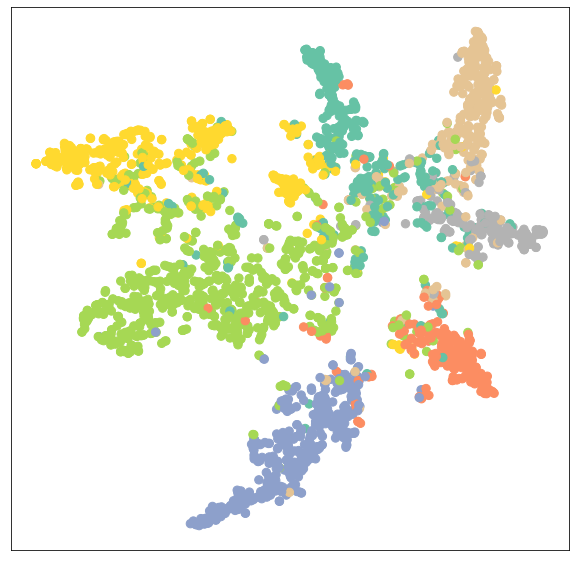

In [32]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)